`Paso 0:` Importar las Librerias

In [ ]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn
import statistics

from pandas.api.types import is_numeric_dtype
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest, chi2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


`Paso 1:` Cargar los datos desde el Drive

In [ ]:
ruta_data_set = 'Data/Base_Fuga_2021.xlsx'
data_set = pd.read_excel(ruta_data_set)

In [ ]:
data_set.head(10)

,CreditMes_T,CreditMes_T-1,CreditMes_T-2,NumTarjCred_T,NumTarjCred_T-1,NumTarjCred_T-2,Ingreso,Edad,NumTransWeb_T,NumTransWeb_T-1,NumTransWeb_T-2,MargenComp_T,MargenComp_T-1,MargenComp_T-2,MargenComp_T-3,MargenComp_T-4,MargenComp_T-5,MargenComp_T-6,Telefono,NivelEduc,Genero,EstCivil,Region,FUGA
0,1031900.0,666500,608000,2.0,2.0,2,1050050,30,1.0,0.0,0,174160.0,227040.0,225880,252700,252800.0,260700.0,195120,SI,UNI,M,SOL,RM,NF
1,1078700.0,634100,583250,0.0,0.0,0,830600,38,0.0,0.0,2,174260.0,227140.0,225880,252800,252860.0,260780.0,196480,SI,TEC,F,CAS,RM,NF
2,1076000.0,708800,621950,1.0,1.0,1,980700,25,0.0,0.0,0,173580.0,227620.0,222980,252840,252580.0,260200.0,195380,SI,UNI,F,SOL,RM,NF
3,995450.0,599900,564350,1.0,1.0,1,1178300,46,0.0,0.0,0,174580.0,227360.0,226300,253160,253280.0,261220.0,197040,SI,TEC,M,CAS,RM,NF
4,1052150.0,609800,572450,1.0,1.0,1,868600,55,6.0,3.0,9,174560.0,227320.0,226200,253140,253040.0,260920.0,196040,SI,MED,F,SOL,RM,NF
5,990500.0,597200,562100,0.0,0.0,0,1476600,43,0.0,0.0,0,175960.0,228220.0,227780,255200,255560.0,262200.0,188460,SI,UNI,M,CAS,RM,NF
6,993200.0,603050,564800,1.0,1.0,1,724200,30,7.0,4.0,3,174440.0,227320.0,226100,252960,253000.0,260900.0,195460,SI,TEC,F,SOL,RM,NF
7,991400.0,597200,562100,1.0,1.0,1,1126050,33,0.0,0.0,0,174680.0,227360.0,226220,253240,253100.0,260920.0,195760,SI,UNI,F,SOL,RM,NF
8,1008500.0,614300,607100,1.0,1.0,1,902800,29,26.0,28.0,41,174620.0,227440.0,225680,252700,252860.0,260740.0,195120,SI,UNI,F,SOL,RM,NF
9,1053950.0,628700,572450,0.0,0.0,1,1743550,30,14.0,14.0,4,175280.0,228680.0,226740,253500,253560.0,261160.0,197500,SI,UNI,M,SOL,RM,NF


`Paso 2:` Estadísticas Descriptivas de los datos

In [ ]:
data_set.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CreditMes_T,5603,NaN,NaN,NaN,1.02148e+06,115217,912650,990500,997700,1.0148e+06,5e+06
CreditMes_T-1,5605,NaN,NaN,NaN,632812,127734,500000,597200,604850,623300,5e+06
CreditMes_T-2,5605,NaN,NaN,NaN,583796,80016.5,500000,562100,566150,577400,3.49835e+06
NumTarjCred_T,5598,NaN,NaN,NaN,0.831011,0.701989,0,0,1,1,9
NumTarjCred_T-1,5603,NaN,NaN,NaN,0.829734,0.716208,0,0,1,1,9
NumTarjCred_T-2,5605,NaN,NaN,NaN,0.836931,0.728113,0,0,1,1,9
Ingreso,5605,NaN,NaN,NaN,1.2238e+06,562273,-975950,890450,1.05765e+06,1.3626e+06,9.62855e+06
Edad,5605,NaN,NaN,NaN,35.9165,9.21777,15,29,33,41,131
NumTransWeb_T,5603,NaN,NaN,NaN,5.2131,11.3298,0,0,0,6,142
NumTransWeb_T-1,5603,NaN,NaN,NaN,3.9295,8.49904,0,0,1,5,159


In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5605 entries, 0 to 5604
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditMes_T      5603 non-null   float64
 1   CreditMes_T-1    5605 non-null   int64  
 2   CreditMes_T-2    5605 non-null   int64  
 3   NumTarjCred_T    5598 non-null   float64
 4   NumTarjCred_T-1  5603 non-null   float64
 5   NumTarjCred_T-2  5605 non-null   int64  
 6   Ingreso          5605 non-null   int64  
 7   Edad             5605 non-null   int64  
 8   NumTransWeb_T    5603 non-null   float64
 9   NumTransWeb_T-1  5603 non-null   float64
 10  NumTransWeb_T-2  5605 non-null   int64  
 11  MargenComp_T     5603 non-null   float64
 12  MargenComp_T-1   5604 non-null   float64
 13  MargenComp_T-2   5605 non-null   int64  
 14  MargenComp_T-3   5605 non-null   int64  
 15  MargenComp_T-4   5603 non-null   float64
 16  MargenComp_T-5   5604 non-null   float64
 17  MargenComp_T-6

`Paso 3:` Estimar la cantidad de valores nulos o NaN que existen dentro de los datos, dependiendo del % de se verá que hacer con estos valores. De ser inferior al 5% se pueden considerar dos posibles soluciones. Una primera opción es reemplazar los NaN con la media/mediana/moda dependiendo de lo que aplique mejor al caso. La segunda opción es eliminar la fila en donde existe al menos 1 NaN presente. Para este caso, se portará por tomar la #2, esto ya que lo que se espera obtener es un modelo en el cual sea posible de detectar posibles fraudes y anticipar algún cliente riesgoso, esto basandose en principio en las 5 mejores variables dentro del total presentadas. Se argumenta que es mas importante que el modelo sea lo mas preciso posible, por lo que se cree que la alternativa #1 no aporta mucho y es mejor descartar los datos que tengan este tipo de problema. 

En el caso de que la cantidad de datos sea superior al 25%, se evaluará la opción de imputar datos faltantes ya que estos representan una gran proporcion de datos NaN, lo que puede contaminar los resultados eliminarlos o utilizar metodos menos sofisticados como lo son en la alternativa #1.


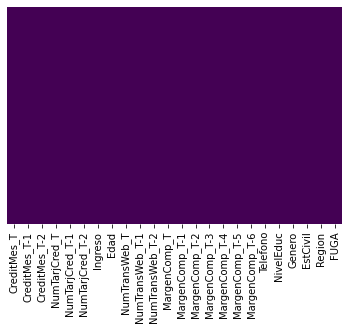

In [ ]:
sn.heatmap(data_set.isnull(), yticklabels=False, cbar=False, cmap='viridis');

In [ ]:
data_set.isnull().sum()

CreditMes_T        2
CreditMes_T-1      0
CreditMes_T-2      0
NumTarjCred_T      7
NumTarjCred_T-1    2
NumTarjCred_T-2    0
Ingreso            0
Edad               0
NumTransWeb_T      2
NumTransWeb_T-1    2
NumTransWeb_T-2    0
MargenComp_T       2
MargenComp_T-1     1
MargenComp_T-2     0
MargenComp_T-3     0
MargenComp_T-4     2
MargenComp_T-5     1
MargenComp_T-6     0
Telefono           0
NivelEduc          3
Genero             0
EstCivil           2
Region             0
FUGA               0
dtype: int64

Crear una función que cree un reporte con respecto a los valores NaN presentes en un data set.

In [ ]:
def NaN_report(df):
  df_cols_list = [column_name for column_name in df.columns]
  print("REPORTE DE VALORES FALTANTES/NAN")
  print()
  for index, column_name in enumerate(df_cols_list):
    nan_yes = df[column_name].isnull().sum()
    nan_no = df[column_name].notnull().sum()
    total = (nan_yes + nan_no)
    print(f"{index+1}) Nombre de la Columna/Variable: {column_name}")
    print(f"Cantidad total de {total} Valores en la Columna, {nan_no} corresponden a NO NAN")
    print(f"La cantidad de valores NaN presentes son: {nan_yes} - {round((nan_yes/total * 100), 4)}%")
    print('\n')

In [ ]:
NaN_report(data_set)

REPORTE DE VALORES FALTANTES/NAN

1) Nombre de la Columna/Variable: CreditMes_T
Cantidad total de 5605 Valores en la Columna, 5603 corresponden a NO NAN
La cantidad de valores NaN presentes son: 2 - 0.0357%


2) Nombre de la Columna/Variable: CreditMes_T-1
Cantidad total de 5605 Valores en la Columna, 5605 corresponden a NO NAN
La cantidad de valores NaN presentes son: 0 - 0.0%


3) Nombre de la Columna/Variable: CreditMes_T-2
Cantidad total de 5605 Valores en la Columna, 5605 corresponden a NO NAN
La cantidad de valores NaN presentes son: 0 - 0.0%


4) Nombre de la Columna/Variable: NumTarjCred_T
Cantidad total de 5605 Valores en la Columna, 5598 corresponden a NO NAN
La cantidad de valores NaN presentes son: 7 - 0.1249%


5) Nombre de la Columna/Variable: NumTarjCred_T-1
Cantidad total de 5605 Valores en la Columna, 5603 corresponden a NO NAN
La cantidad de valores NaN presentes son: 2 - 0.0357%


6) Nombre de la Columna/Variable: NumTarjCred_T-2
Cantidad total de 5605 Valores en la 

Como se puede ver, para todas la variables que se presentan en el data set, la cantidad de valores NaN es despreciable, por lo que optará por considerar la alternativa #2, por lo tanto estas filas serán eliminadas del data set.

In [ ]:
data_set = data_set.dropna(axis=0, how='any')

Corroborando que ya no existen datos nulos

In [ ]:
data_set.isna().sum()

CreditMes_T        0
CreditMes_T-1      0
CreditMes_T-2      0
NumTarjCred_T      0
NumTarjCred_T-1    0
NumTarjCred_T-2    0
Ingreso            0
Edad               0
NumTransWeb_T      0
NumTransWeb_T-1    0
NumTransWeb_T-2    0
MargenComp_T       0
MargenComp_T-1     0
MargenComp_T-2     0
MargenComp_T-3     0
MargenComp_T-4     0
MargenComp_T-5     0
MargenComp_T-6     0
Telefono           0
NivelEduc          0
Genero             0
EstCivil           0
Region             0
FUGA               0
dtype: int64

`Paso 4:` El siguiente paso va a ser buscar inconsistencias en los datos presentes. Estas se presentan en distintas formas y por lo usual son faciles de identificar, por ejemplo si se toma la columna Edad se espera que no existan edades negativas o iguales a cero, o en el caso del ingreso buscar si existen ingresos negativos.

In [ ]:
data_set['Edad'].value_counts(ascending=True)

131      1
15       1
127      1
72       1
80       1
75       2
71       2
19       2
76       2
70       3
69       3
73       4
65       7
68       7
67       8
20       9
66      10
64      13
60      13
63      15
62      16
59      17
21      27
57      30
58      30
55      34
56      37
54      46
52      48
22      48
53      54
48      58
51      61
50      67
23      87
45     101
46     102
47     107
44     113
43     129
42     130
25     142
39     182
41     187
26     199
38     203
40     211
36     229
35     242
34     252
27     283
33     299
28     307
32     329
30     342
31     362
29     363
Name: Edad, dtype: int64

Value_counts permite identificar los valores únicos, en este caso para las edad y contar la cantidad de veces que este se repite dentro de los datos.

Se puede ver al pricipio se ven los que menos se repiten, y dentro de esta aparecen dos valores de edades muy extremos los cuales son 131 años y 127 años. Estos valores claramente son erroneos, como son solamente estos dos, se eliminarán del data set. Para eliminarlos, todos los valores de la fila serán transformados a NaN para luego ser borrados.

In [ ]:
data_set[(data_set['Edad'] == 127) | (data_set['Edad'] == 131) | (data_set['Edad'] == 15)] = np.nan

In [ ]:
data_set.isnull().sum()

CreditMes_T        3
CreditMes_T-1      3
CreditMes_T-2      3
NumTarjCred_T      3
NumTarjCred_T-1    3
NumTarjCred_T-2    3
Ingreso            3
Edad               3
NumTransWeb_T      3
NumTransWeb_T-1    3
NumTransWeb_T-2    3
MargenComp_T       3
MargenComp_T-1     3
MargenComp_T-2     3
MargenComp_T-3     3
MargenComp_T-4     3
MargenComp_T-5     3
MargenComp_T-6     3
Telefono           3
NivelEduc          3
Genero             3
EstCivil           3
Region             3
FUGA               3
dtype: int64

In [ ]:
data_set = data_set.dropna(axis=0, how='any')

Corroborar que no existen NaN en el data set

In [ ]:
data_set.isnull().sum()

CreditMes_T        0
CreditMes_T-1      0
CreditMes_T-2      0
NumTarjCred_T      0
NumTarjCred_T-1    0
NumTarjCred_T-2    0
Ingreso            0
Edad               0
NumTransWeb_T      0
NumTransWeb_T-1    0
NumTransWeb_T-2    0
MargenComp_T       0
MargenComp_T-1     0
MargenComp_T-2     0
MargenComp_T-3     0
MargenComp_T-4     0
MargenComp_T-5     0
MargenComp_T-6     0
Telefono           0
NivelEduc          0
Genero             0
EstCivil           0
Region             0
FUGA               0
dtype: int64

Corroborar que no existan inconcistencias en los Ingresos

Para la columna Ingresos se buscan valores que sean negativos o iguales a 0



In [ ]:
print(f"Cantidad de Inconsistencias: {((data_set['Ingreso'] <= 0).sum())}")
print(f"- Valores son Negativos: {((data_set['Ingreso'] < 0).sum())}")
print(f"- Valores iguales a Cero: {((data_set['Ingreso'] == 0).sum())}")
print('\n')
print(f"- Mediana: {(data_set['Ingreso'].median())}")
print(f"- Promedio: {(data_set['Ingreso'].mean())}")
print(f"- Moda: {(statistics.mode(list(data_set['Ingreso'])))}")

Cantidad de Inconsistencias: 4
- Valores son Negativos: 1
- Valores iguales a Cero: 3


- Mediana: 1058125.0
- Promedio: 1224727.743902439
- Moda: 867650.0


In [ ]:
data_set[(data_set['Ingreso'] < 0)]['Ingreso']

4425   -975950.0
Name: Ingreso, dtype: float64

El valor negativo seguramente fue un error de signo, por lo que la mejor manera de arreglar esto de manera muy sencilla y sin afectar al resto de los datos es aplicar la función valor absoluto a esta columna.

In [ ]:
data_set['Ingreso'] = data_set['Ingreso'].apply(lambda x: abs(x))

In [ ]:
data_set[(data_set['Ingreso'] < 0)]

,CreditMes_T,CreditMes_T-1,CreditMes_T-2,NumTarjCred_T,NumTarjCred_T-1,NumTarjCred_T-2,Ingreso,Edad,NumTransWeb_T,NumTransWeb_T-1,NumTransWeb_T-2,MargenComp_T,MargenComp_T-1,MargenComp_T-2,MargenComp_T-3,MargenComp_T-4,MargenComp_T-5,MargenComp_T-6,Telefono,NivelEduc,Genero,EstCivil,Region,FUGA


In [ ]:
data_set[(data_set['Ingreso'] == data_set['Ingreso'].median()) | (data_set['Ingreso'] == 867650.0)]['Ingreso'].value_counts(ascending=True)

867650.0    83
Name: Ingreso, dtype: int64

**PENDIENTE**
Escoger entre la Mediana o la Moda para rellenar los datos inconsistentes. Un punto a favor es la moda ya que tiene un total de 83 apariciones en los datos, mientras que el dato que corresponde a la mediana solamente se repite 6 veces. El promedio se puede descartar ya que se ve que es muy alto con respecto a la moda y la mediana.

In [ ]:
# Se puede modificar, se reemplazaran por la Moda
data_set['Ingreso'] = data_set['Ingreso'].replace(0, 867650.0)

Corroborar que no existen valores cero o valores negativos

In [ ]:
(data_set['Ingreso'] <= 0).sum()

0

In [ ]:
data_set['Edad'].value_counts(ascending=True)

72.0      1
80.0      1
71.0      2
76.0      2
75.0      2
19.0      2
70.0      3
69.0      3
73.0      4
65.0      7
68.0      7
67.0      8
20.0      9
66.0     10
64.0     13
60.0     13
63.0     15
62.0     16
59.0     17
21.0     27
58.0     30
57.0     30
55.0     34
56.0     37
54.0     46
52.0     48
22.0     48
53.0     54
48.0     58
51.0     61
50.0     67
23.0     87
45.0    101
46.0    102
47.0    107
44.0    113
43.0    129
42.0    130
25.0    142
39.0    182
41.0    187
26.0    199
38.0    203
40.0    211
36.0    229
35.0    242
34.0    252
27.0    283
33.0    299
28.0    307
32.0    329
30.0    342
31.0    362
29.0    363
Name: Edad, dtype: int64

Columna Ingresos no presenta inconsistencias

Se repetirá un proceso similar con Nivel Educacional

In [ ]:
data_set['NivelEduc'].value_counts(ascending=True)

EST_UNI      75
MED         107
TEC        1787
UNI        3607
Name: NivelEduc, dtype: int64

Columna NivelEduc no presenta inconsistencias, es posible agrupar EST_UNI y MED en una única categoría ya que no aportan mucho por si solas cada una

Se repetirá lo mismo para Genero

In [ ]:
data_set['Genero'].value_counts(ascending=True)

H      29
F    1669
M    3878
Name: Genero, dtype: int64

**DUDA:** 
¿A qué categoría corresponde la letra H? ¿Será H por el español? 

In [ ]:
# Se puede Modificar, se reemplazo H por M
data_set['Genero'] = data_set['Genero'].replace('H', 'M')

In [ ]:
data_set['Genero'].value_counts(ascending=True)

F    1669
M    3907
Name: Genero, dtype: int64

In [ ]:
data_set['EstCivil'].value_counts(ascending=True)

VIU      26
DIV     264
SOL    2339
CAS    2947
Name: EstCivil, dtype: int64

Columna Estado Civil no presenta inconsistencias. 

Se puede ver que entre VIU y DIV suman entre los dos una proporción muy pequeña con respecto a SOL y CAS.

In [ ]:
data_set['Region'].value_counts(ascending=True)

RM    5576
Name: Region, dtype: int64

La columna Región consta solamente de un único valor, por lo que no aporta ninguna información y por lo tanto no será considerada para el modelo.

In [ ]:
data_set['FUGA'].value_counts(ascending=True)

F      713
NF    4863
Name: FUGA, dtype: int64

Corroborado: No existen inconsistencias en la Variable Objetivo FUGA

In [ ]:
data_set['Telefono'].value_counts(ascending=True)

SI    5576
Name: Telefono, dtype: int64

La columna Telefono consta solamente de un único valor, por lo que no aporta ninguna información y por lo tanto no será considerada para el modelo.

`Paso 5:` **Gráficos Descriptivos de los Datos**

Histograma de la Edad

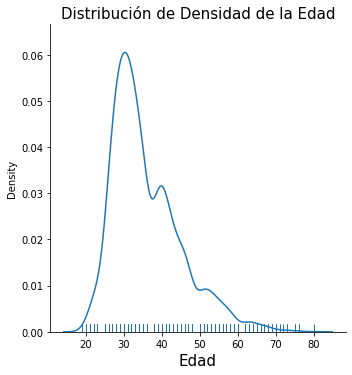

In [ ]:
sn.displot(x=data_set['Edad'], kind='kde', rug=True)
plt.title("Distribución de Densidad de la Edad", fontdict={'fontsize': 15})
plt.xlabel('Edad', fontdict={'fontsize': 15})
plt.show()

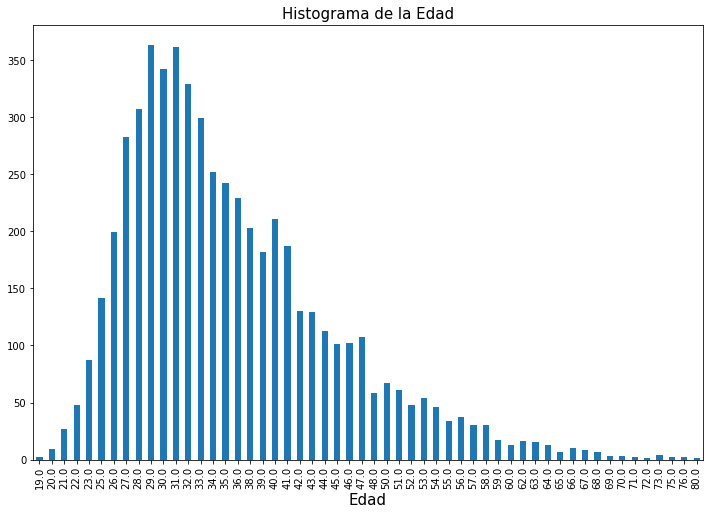

In [ ]:
data_set['Edad'].value_counts().sort_index().plot.bar(figsize=(12,8))
plt.title("Histograma de la Edad", fontdict={'fontsize': 15})
plt.xlabel('Edad', fontdict={'fontsize': 15})
plt.show()

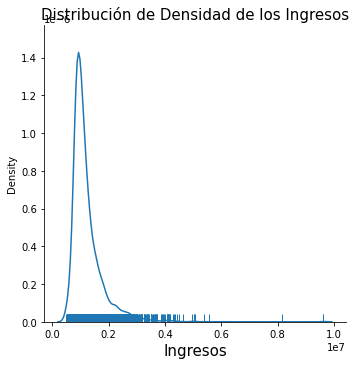

In [ ]:
sn.displot(x=data_set['Ingreso'], kind='kde', rug=True)
plt.title("Distribución de Densidad de los Ingresos", fontdict={'fontsize': 15})
plt.xlabel('Ingresos', fontdict={'fontsize': 15})
plt.show()

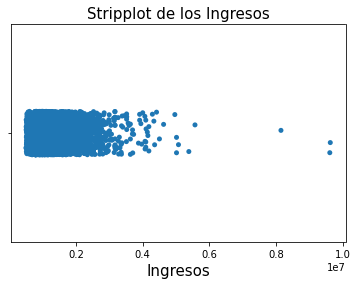

In [ ]:
sn.stripplot(x='Ingreso', data=data_set) 
plt.title("Stripplot de los Ingresos", fontdict={'fontsize': 15})
plt.xlabel('Ingresos', fontdict={'fontsize': 15})
plt.show()

In [ ]:
data_set.head()

,CreditMes_T,CreditMes_T-1,CreditMes_T-2,NumTarjCred_T,NumTarjCred_T-1,NumTarjCred_T-2,Ingreso,Edad,NumTransWeb_T,NumTransWeb_T-1,NumTransWeb_T-2,MargenComp_T,MargenComp_T-1,MargenComp_T-2,MargenComp_T-3,MargenComp_T-4,MargenComp_T-5,MargenComp_T-6,Telefono,NivelEduc,Genero,EstCivil,Region,FUGA
0,1031900.0,666500.0,608000.0,2.0,2.0,2.0,1050050.0,30.0,1.0,0.0,0.0,174160.0,227040.0,225880.0,252700.0,252800.0,260700.0,195120.0,SI,UNI,M,SOL,RM,NF
1,1078700.0,634100.0,583250.0,0.0,0.0,0.0,830600.0,38.0,0.0,0.0,2.0,174260.0,227140.0,225880.0,252800.0,252860.0,260780.0,196480.0,SI,TEC,F,CAS,RM,NF
2,1076000.0,708800.0,621950.0,1.0,1.0,1.0,980700.0,25.0,0.0,0.0,0.0,173580.0,227620.0,222980.0,252840.0,252580.0,260200.0,195380.0,SI,UNI,F,SOL,RM,NF
3,995450.0,599900.0,564350.0,1.0,1.0,1.0,1178300.0,46.0,0.0,0.0,0.0,174580.0,227360.0,226300.0,253160.0,253280.0,261220.0,197040.0,SI,TEC,M,CAS,RM,NF
4,1052150.0,609800.0,572450.0,1.0,1.0,1.0,868600.0,55.0,6.0,3.0,9.0,174560.0,227320.0,226200.0,253140.0,253040.0,260920.0,196040.0,SI,MED,F,SOL,RM,NF


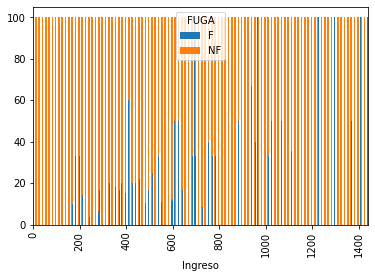

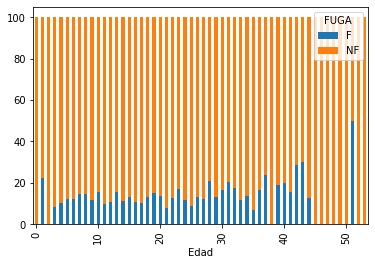

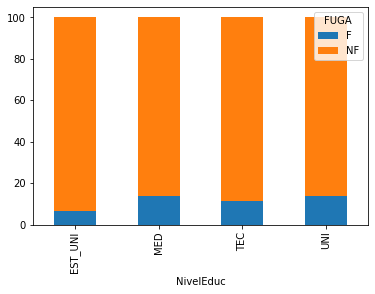

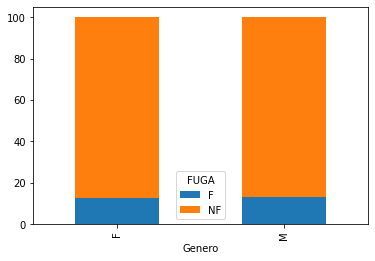

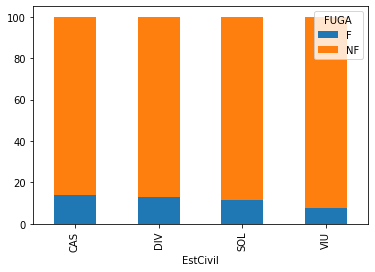

In [ ]:
# PRIMEROS GRAFICOS, SIN JUNTAR CATEGORÍAS PARA PODER HACER DESPUES LA COMPARACIÓN (EstCivil + NivelEduc)

data_set.groupby(['Ingreso', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.xscale('linear')
plt.show()
data_set.groupby(['Edad', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.xscale('linear')
plt.show()
data_set.groupby(['NivelEduc', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()
data_set.groupby(['Genero', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()
data_set.groupby(['EstCivil', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()

Para poder hacer modificaciones sobre los datos originales, se va a crear una copia del data set

In [ ]:
df2 = data_set.copy()
df2.tail()

,CreditMes_T,CreditMes_T-1,CreditMes_T-2,NumTarjCred_T,NumTarjCred_T-1,NumTarjCred_T-2,Ingreso,Edad,NumTransWeb_T,NumTransWeb_T-1,NumTransWeb_T-2,MargenComp_T,MargenComp_T-1,MargenComp_T-2,MargenComp_T-3,MargenComp_T-4,MargenComp_T-5,MargenComp_T-6,Telefono,NivelEduc,Genero,EstCivil,Region,FUGA
5600,989600.0,596300.0,561650.0,0.0,0.0,0.0,972150.0,26.0,0.0,0.0,0.0,174300.0,227040.0,226000.0,252840.0,252960.0,260800.0,195380.0,SI,UNI,F,SOL,RM,F
5601,990050.0,597200.0,562100.0,1.0,1.0,1.0,992100.0,33.0,15.0,1.0,0.0,175060.0,227240.0,226660.0,253520.0,242060.0,261100.0,197120.0,SI,UNI,M,SOL,RM,F
5602,990050.0,596750.0,562100.0,0.0,0.0,0.0,851500.0,30.0,0.0,0.0,4.0,174340.0,227020.0,226040.0,252860.0,252980.0,260820.0,195420.0,SI,TEC,M,CAS,RM,F
5603,990500.0,596750.0,562100.0,0.0,0.0,0.0,3693900.0,58.0,0.0,0.0,0.0,174940.0,300000.0,169020.0,249980.0,253320.0,261240.0,198440.0,SI,UNI,F,VIU,RM,F
5604,990500.0,597200.0,562100.0,2.0,0.0,0.0,866700.0,20.0,0.0,0.0,0.0,174300.0,227040.0,226000.0,252840.0,252960.0,260800.0,195380.0,SI,UNI,M,SOL,RM,F


`Paso 6:` Agegación. Este proceso consiste en agrupar 2 o mas categorías en una categoría.

De todas las variables categóricas, en NivelEduc y en EstCivil existen categorías que son tan pequeñas en proporción con otras, por lo que agrupar estas en un única categoría es buena idea.

Para el caso de NivelEduc, creará una nueva categoría que se llamará EST_UNI/MED.

Para el caso de EstCivil, creará una nueva categoría que se llamará DIV/VIU.

In [ ]:
df2['EstCivil'] = df2['EstCivil'].replace(['DIV', 'VIU'], ['DIV/VIU', 'DIV/VIU'])
df2['NivelEduc'] = df2['NivelEduc'].replace(['EST_UNI', 'MED'], ['EST_UNI/MED', 'EST_UNI/MED'])

Corroborando el cambio

In [ ]:
df2.loc[:, ['EstCivil', 'NivelEduc']].value_counts()

EstCivil  NivelEduc  
CAS       UNI            1892
SOL       UNI            1555
CAS       TEC             973
SOL       TEC             699
DIV/VIU   UNI             160
          TEC             115
SOL       EST_UNI/MED      85
CAS       EST_UNI/MED      82
DIV/VIU   EST_UNI/MED      15
dtype: int64

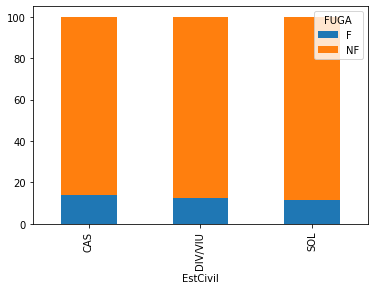

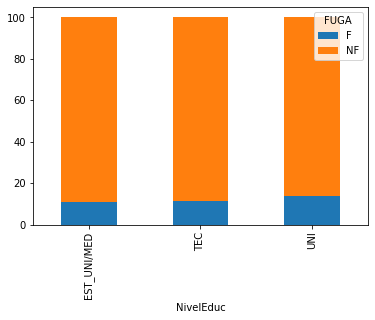

In [ ]:
df2.groupby(['EstCivil', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()
df2.groupby(['NivelEduc', 'FUGA']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot.bar(stacked=True) 
plt.show()

De igual manera, se puede ver que existe cierta tendencia a una centralidad en las variables que se muestran a continuación.

Una buena forma de arreglar esto es ajustar su escala aplicando un logaritmo a estas variables.

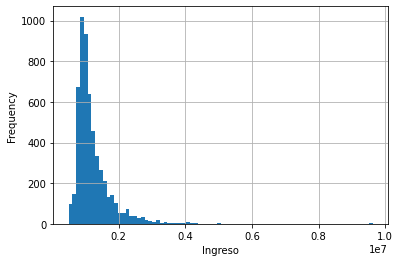

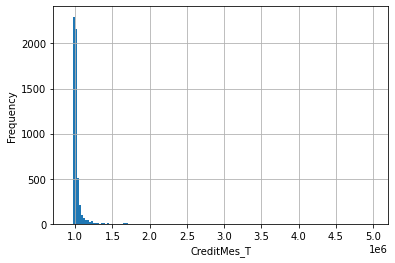

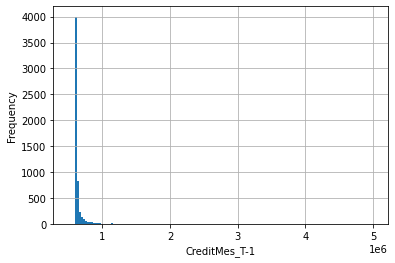

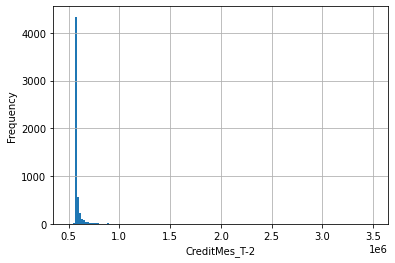

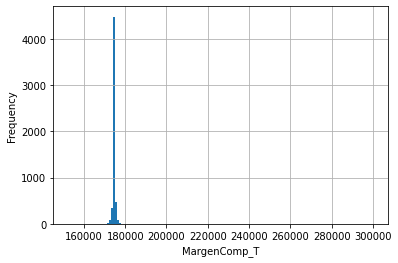

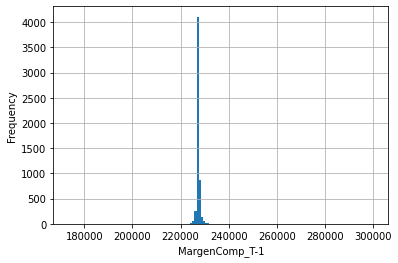

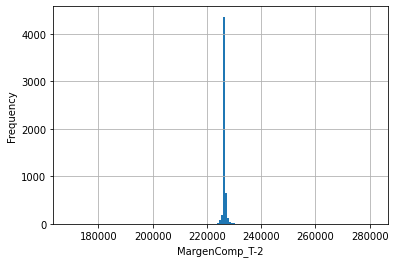

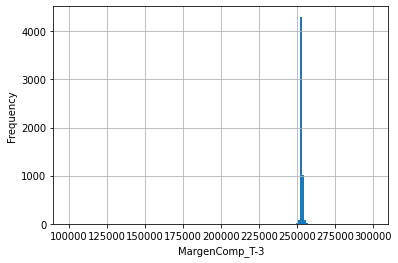

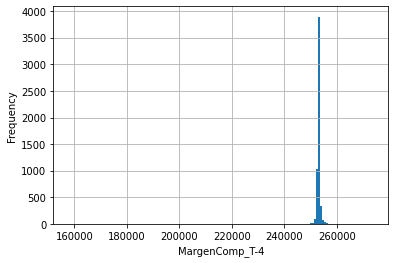

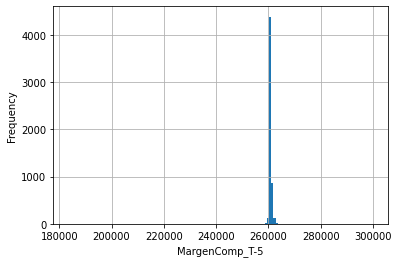

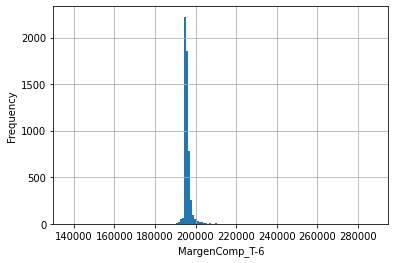

In [ ]:
df2['Ingreso'].plot(kind='hist',bins=80, grid=True )
plt.xlabel('Ingreso')
plt.show()
df2['CreditMes_T'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('CreditMes_T')
plt.show()
df2['CreditMes_T-1'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('CreditMes_T-1')
plt.show()
df2['CreditMes_T-2'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('CreditMes_T-2')
plt.show()
df2['MargenComp_T'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T')
plt.show()
df2['MargenComp_T-1'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-1')
plt.show()
df2['MargenComp_T-2'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-2')
plt.show()
df2['MargenComp_T-3'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-3')
plt.show()
df2['MargenComp_T-4'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-4')
plt.show()
df2['MargenComp_T-5'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-5')
plt.show()
df2['MargenComp_T-6'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('MargenComp_T-6')
plt.show()

In [ ]:
df2['Ln_Ingreso'] = np.log(df2['Ingreso']+1)
df2['Ln_CreditMes_T'] = np.log(df2['CreditMes_T']+1)
df2['Ln_CreditMes_T-1'] = np.log(df2['CreditMes_T-1']+1)
df2['Ln_CreditMes_T-2'] = np.log(df2['CreditMes_T-2']+1)
df2['Ln_MargenComp_T'] = np.log(df2['MargenComp_T']+1)
df2['Ln_MargenComp_T-1'] = np.log(df2['MargenComp_T-1']+1)
df2['Ln_MargenComp_T-2'] = np.log(df2['MargenComp_T-2']+1)
df2['Ln_MargenComp_T-3'] = np.log(df2['MargenComp_T-3']+1)
df2['Ln_MargenComp_T-4'] = np.log(df2['MargenComp_T-4']+1)
df2['Ln_MargenComp_T-5'] = np.log(df2['MargenComp_T-5']+1)
df2['Ln_MargenComp_T-6'] = np.log(df2['MargenComp_T-6']+1)

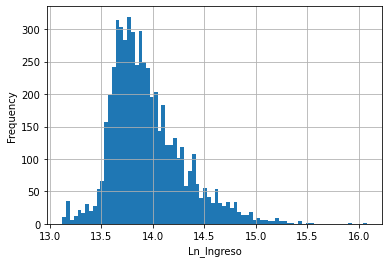

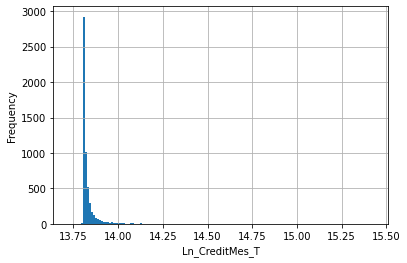

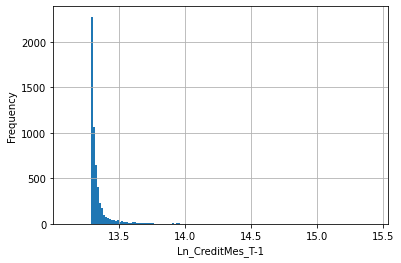

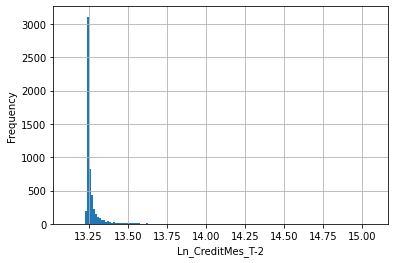

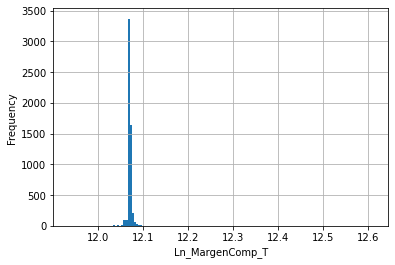

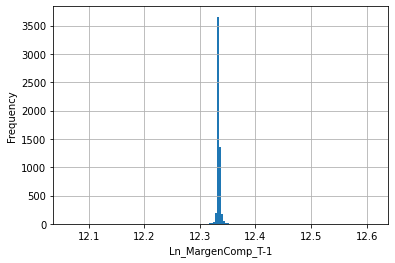

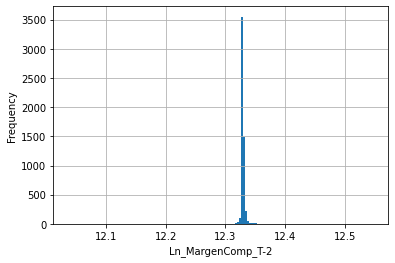

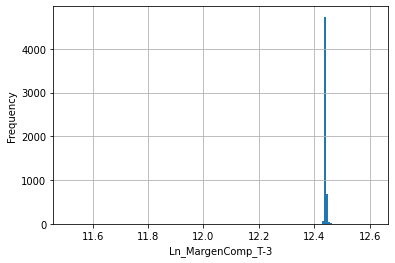

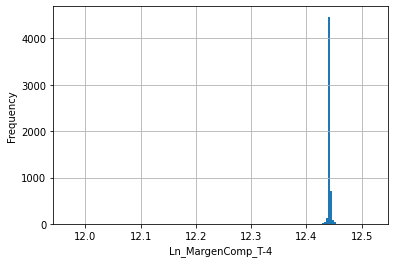

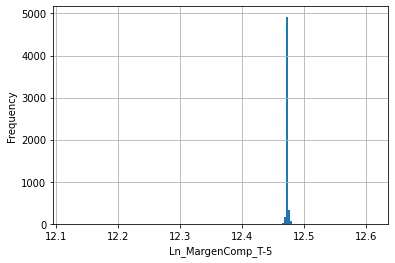

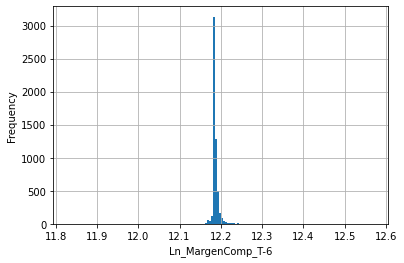

In [ ]:
df2['Ln_Ingreso'].plot(kind='hist',bins=80, grid=True )
plt.xlabel('Ln_Ingreso')
plt.show()
df2['Ln_CreditMes_T'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_CreditMes_T')
plt.show()
df2['Ln_CreditMes_T-1'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_CreditMes_T-1')
plt.show()
df2['Ln_CreditMes_T-2'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_CreditMes_T-2')
plt.show()
df2['Ln_MargenComp_T'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T')
plt.show()
df2['Ln_MargenComp_T-1'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-1')
plt.show()
df2['Ln_MargenComp_T-2'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-2')
plt.show()
df2['Ln_MargenComp_T-3'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-3')
plt.show()
df2['Ln_MargenComp_T-4'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-4')
plt.show()
df2['Ln_MargenComp_T-5'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-5')
plt.show()
df2['Ln_MargenComp_T-6'].plot(kind='hist',bins=150, grid=True )
plt.xlabel('Ln_MargenComp_T-6')
plt.show()

Crear variables encajonadas de Edad y de Ingresos

In [ ]:
cut_points = df2['Edad'].quantile([0, .2, .4, .6, .8, 1]) 
Age_binned = pd.cut(df2['Edad'], bins =cut_points, include_lowest= True )
print(Age_binned)
df2['Rangos de Edad'] = Age_binned

0         (29.0, 32.0]
1         (36.0, 43.0]
2       (18.999, 29.0]
3         (43.0, 80.0]
4         (43.0, 80.0]
             ...      
5600    (18.999, 29.0]
5601      (32.0, 36.0]
5602      (29.0, 32.0]
5603      (43.0, 80.0]
5604    (18.999, 29.0]
Name: Edad, Length: 5576, dtype: category
Categories (5, interval[float64]): [(18.999, 29.0] < (29.0, 32.0] < (32.0, 36.0] < (36.0, 43.0] <
                                    (43.0, 80.0]]


In [ ]:
df2.loc[:, ['Rangos de Edad', 'FUGA']].value_counts()

Rangos de Edad  FUGA
(18.999, 29.0]  NF      1282
(36.0, 43.0]    NF       914
(29.0, 32.0]    NF       909
(32.0, 36.0]    NF       891
(43.0, 80.0]    NF       867
(18.999, 29.0]  F        185
(43.0, 80.0]    F        145
(32.0, 36.0]    F        131
(36.0, 43.0]    F        128
(29.0, 32.0]    F        124
dtype: int64

In [ ]:
cut_points = df2['Ingreso'].quantile([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]) 
Earnings_binned = pd.cut(df2['Ingreso'], bins =cut_points, include_lowest= True )
print(Earnings_binned)
df2['Rangos por Ingresos'] = Earnings_binned

0        (987350.0, 1058125.0]
1         (796400.0, 867650.0]
2         (923700.0, 987350.0]
3       (1147900.0, 1282800.0]
4         (867650.0, 923700.0]
                 ...          
5600      (923700.0, 987350.0]
5601     (987350.0, 1058125.0]
5602      (796400.0, 867650.0]
5603    (1832850.0, 9628550.0]
5604      (796400.0, 867650.0]
Name: Ingreso, Length: 5576, dtype: category
Categories (10, interval[float64]): [(500949.999, 796400.0] < (796400.0, 867650.0] < (867650.0, 923700.0] <
                                     (923700.0, 987350.0] ... (1147900.0, 1282800.0] <
                                     (1282800.0, 1488950.0] < (1488950.0, 1832850.0] <
                                     (1832850.0, 9628550.0]]


In [ ]:
df2.loc[:, ['Rangos por Ingresos', 'FUGA']].value_counts()

Rangos por Ingresos     FUGA
(796400.0, 867650.0]    NF      535
(500949.999, 796400.0]  NF      502
(923700.0, 987350.0]    NF      495
(1147900.0, 1282800.0]  NF      493
(1832850.0, 9628550.0]  NF      480
(987350.0, 1058125.0]   NF      475
(1488950.0, 1832850.0]  NF      475
(1058125.0, 1147900.0]  NF      470
(1282800.0, 1488950.0]  NF      470
(867650.0, 923700.0]    NF      468
(1058125.0, 1147900.0]  F        90
(1488950.0, 1832850.0]  F        82
(1147900.0, 1282800.0]  F        78
(1832850.0, 9628550.0]  F        78
(1282800.0, 1488950.0]  F        72
(796400.0, 867650.0]    F        67
(987350.0, 1058125.0]   F        65
(923700.0, 987350.0]    F        62
(500949.999, 796400.0]  F        60
(867650.0, 923700.0]    F        59
dtype: int64

Crear Variables Dummy de NivelEduc, Genero, Telefono, EstCivil, Region, FUGA,

In [ ]:
df2 = pd.get_dummies(df2, columns = ["NivelEduc"], drop_first = True)
df2 = pd.get_dummies(df2, columns = ["Genero"], drop_first = True)
df2 = pd.get_dummies(df2, columns = ["Telefono"])
df2 = pd.get_dummies(df2, columns = ["EstCivil"], drop_first = True)
df2 = pd.get_dummies(df2, columns = ["Region"])
df2 = pd.get_dummies(df2, columns = ["Rangos de Edad"], drop_first = True)
df2 = pd.get_dummies(df2, columns = ["Rangos por Ingresos"], drop_first = True)
df2 = pd.get_dummies(df2, columns = ["FUGA"], drop_first = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 5604
Data columns (total 50 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CreditMes_T                                 5576 non-null   float64
 1   CreditMes_T-1                               5576 non-null   float64
 2   CreditMes_T-2                               5576 non-null   float64
 3   NumTarjCred_T                               5576 non-null   float64
 4   NumTarjCred_T-1                             5576 non-null   float64
 5   NumTarjCred_T-2                             5576 non-null   float64
 6   Ingreso                                     5576 non-null   float64
 7   Edad                                        5576 non-null   float64
 8   NumTransWeb_T                               5576 non-null   float64
 9   NumTransWeb_T-1                             5576 non-null   float64
 10  NumTransWeb_

`Paso7:` Selección y Ranking de Atributos

El primer criterio que se utilizará corresponde al de la desviasión estandar de las variables, aquellas que tengan una std igual o muy cernacas a cero no aportan nada al modelo, por lo que se pueden eliminar de los datos.

In [ ]:
df2.std()

CreditMes_T                                   115458.811736
CreditMes_T-1                                 128023.230885
CreditMes_T-2                                  80207.215577
NumTarjCred_T                                      0.702532
NumTarjCred_T-1                                    0.716767
NumTarjCred_T-2                                    0.728752
Ingreso                                       561777.762133
Edad                                               9.045982
NumTransWeb_T                                     11.330986
NumTransWeb_T-1                                    8.483170
NumTransWeb_T-2                                   10.140196
MargenComp_T                                    2041.925321
MargenComp_T-1                                  2415.801570
MargenComp_T-2                                  1971.582261
MargenComp_T-3                                  2477.027917
MargenComp_T-4                                  2552.199996
MargenComp_T-5                          

In [ ]:
del df2['Telefono_SI']
del df2['Region_RM']

Otro criterio que aporta a la busqueda y selección de atributos corresponde a la Redundancia

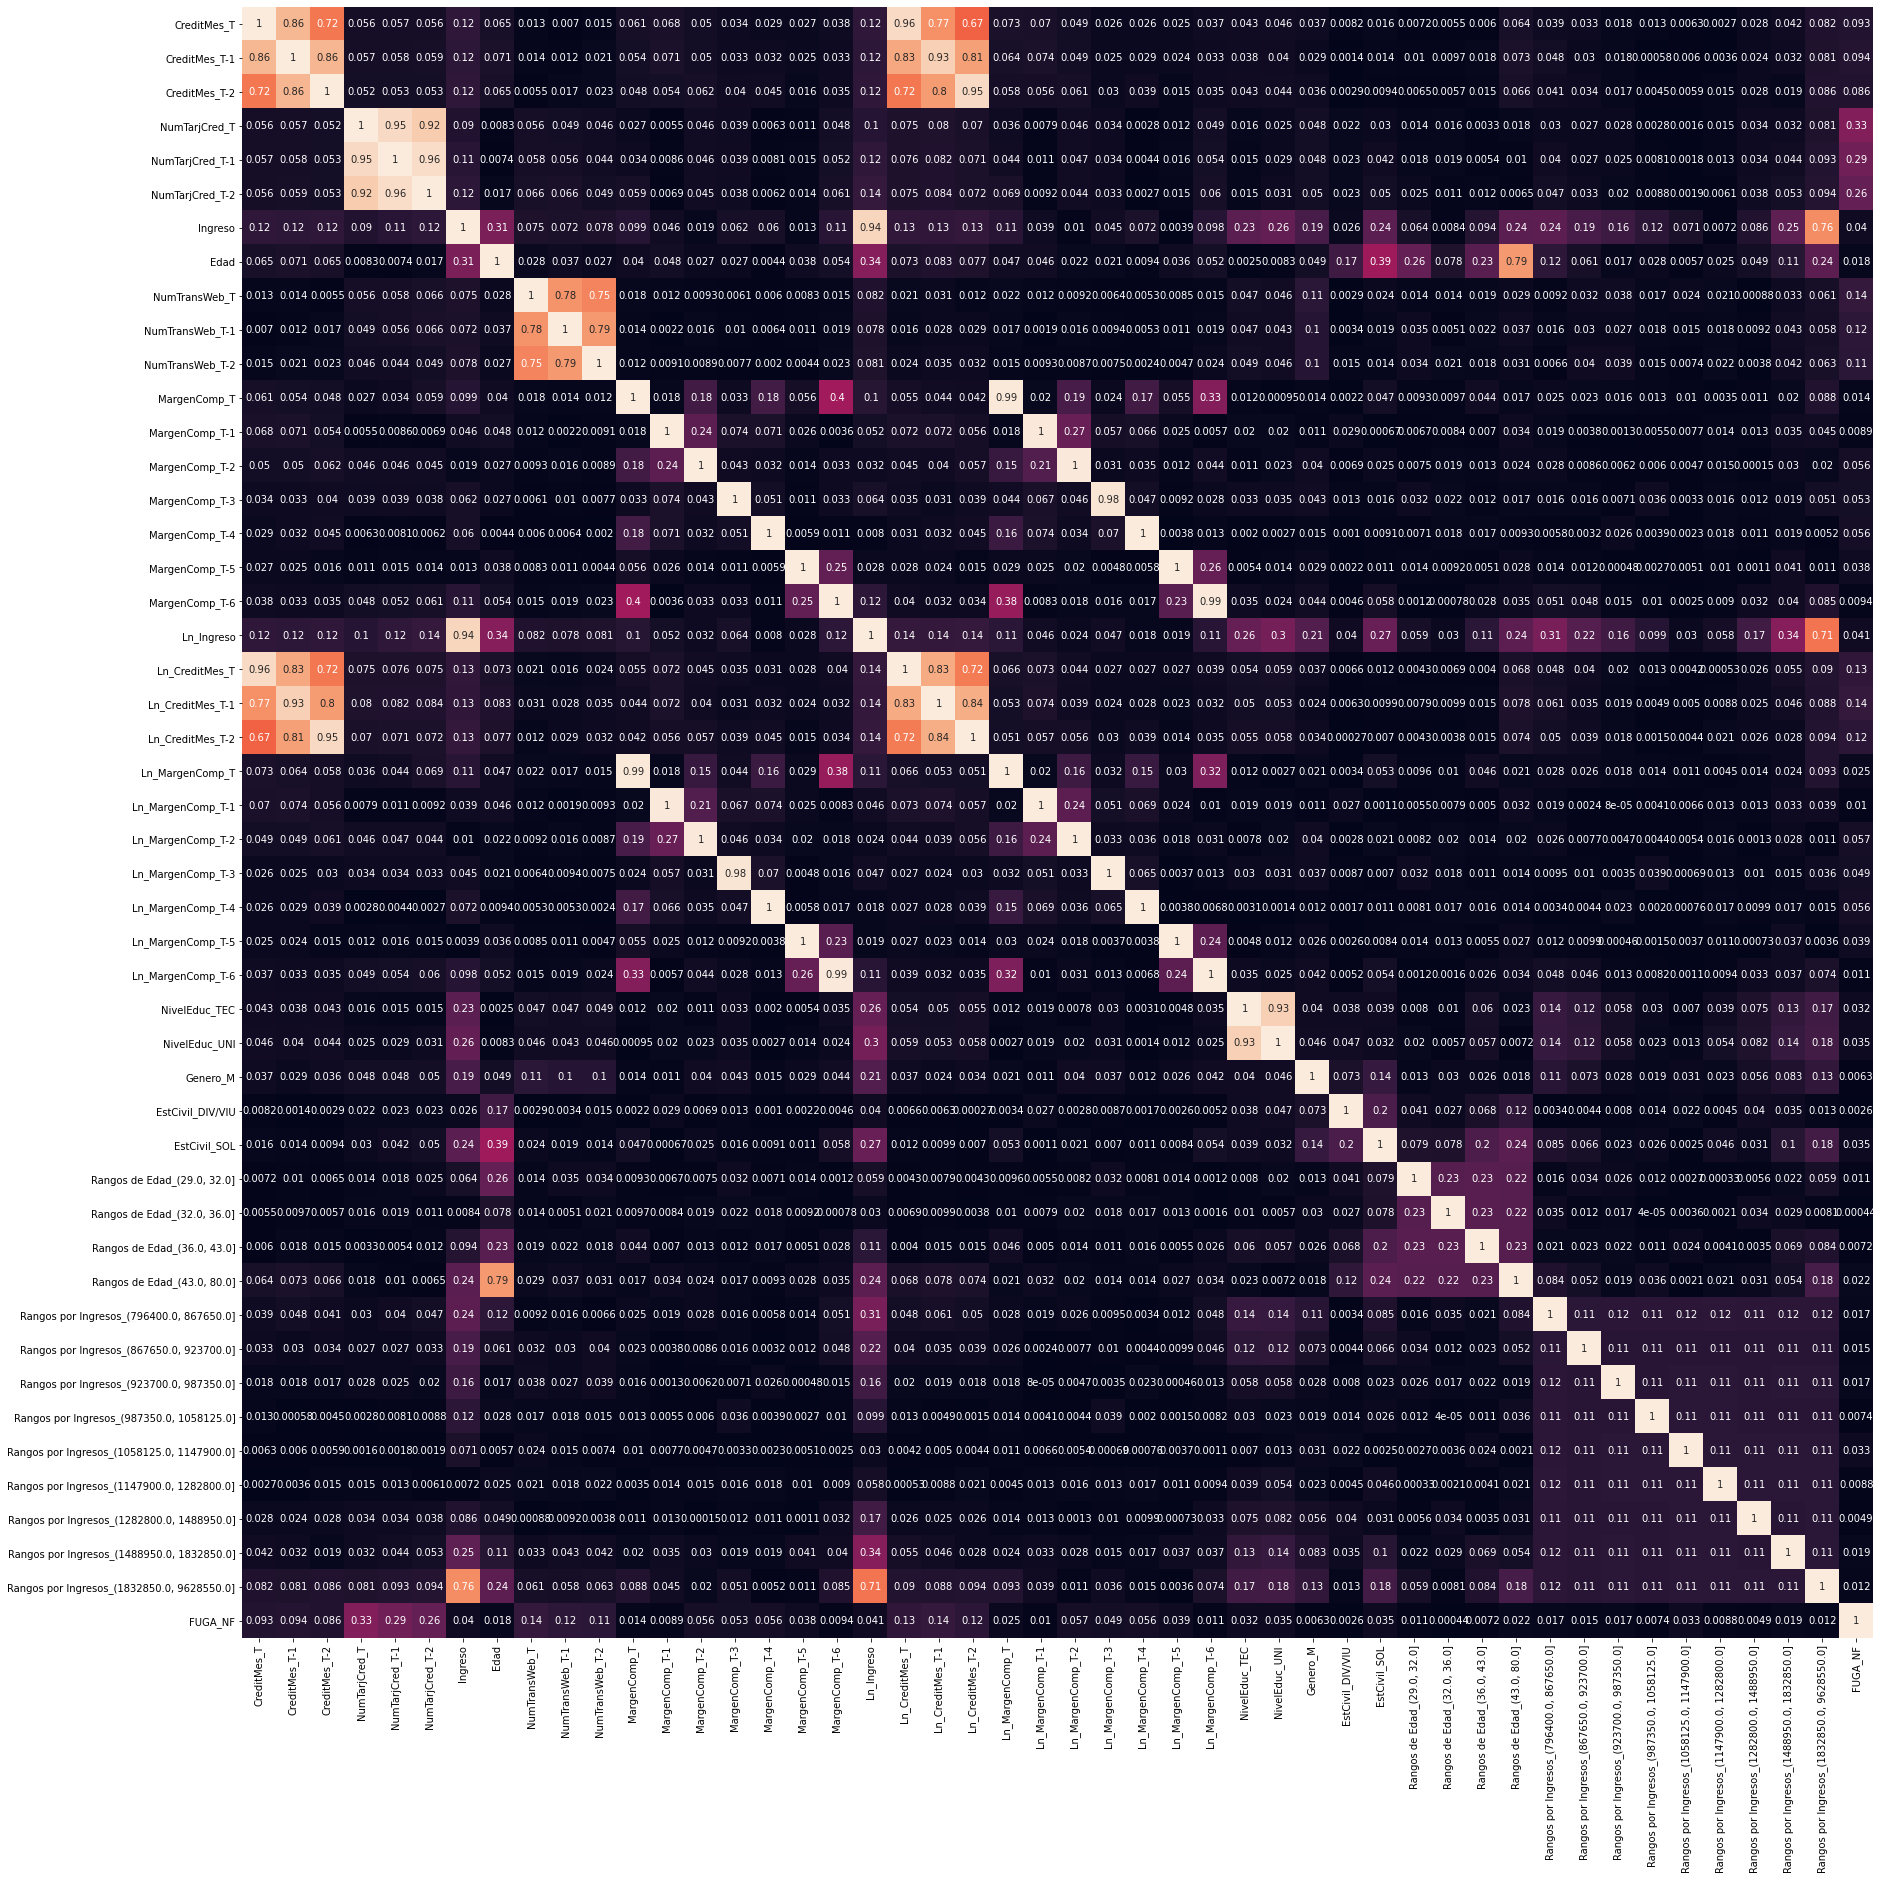

In [ ]:
corrmat = df2.corr().abs()
f, ax = plt.subplots(figsize=(30, 30))
sn.heatmap(corrmat, square=True, annot=True, cbar=False);

Por lo que se puede ver existen valores de correlación entremadamente altos entre variables, por lo que se puede inferir que una variable explica en gran medida a la otra, por lo que no es necesario considerar ambas para la selección del modelo, y bastaría con eliminar las siguientes variables.

In [ ]:
df2.columns

Index(['CreditMes_T', 'CreditMes_T-1', 'CreditMes_T-2', 'NumTarjCred_T',
       'NumTarjCred_T-1', 'NumTarjCred_T-2', 'Ingreso', 'Edad',
       'NumTransWeb_T', 'NumTransWeb_T-1', 'NumTransWeb_T-2', 'MargenComp_T',
       'MargenComp_T-1', 'MargenComp_T-2', 'MargenComp_T-3', 'MargenComp_T-4',
       'MargenComp_T-5', 'MargenComp_T-6', 'Ln_Ingreso', 'Ln_CreditMes_T',
       'Ln_CreditMes_T-1', 'Ln_CreditMes_T-2', 'Ln_MargenComp_T',
       'Ln_MargenComp_T-1', 'Ln_MargenComp_T-2', 'Ln_MargenComp_T-3',
       'Ln_MargenComp_T-4', 'Ln_MargenComp_T-5', 'Ln_MargenComp_T-6',
       'NivelEduc_TEC', 'NivelEduc_UNI', 'Genero_M', 'EstCivil_DIV/VIU',
       'EstCivil_SOL', 'Rangos de Edad_(29.0, 32.0]',
       'Rangos de Edad_(32.0, 36.0]', 'Rangos de Edad_(36.0, 43.0]',
       'Rangos de Edad_(43.0, 80.0]',
       'Rangos por Ingresos_(796400.0, 867650.0]',
       'Rangos por Ingresos_(867650.0, 923700.0]',
       'Rangos por Ingresos_(923700.0, 987350.0]',
       'Rangos por Ingresos_(987350.0,

Criterio de Relevancia entre el rango de edad y rango de ingreso

In [ ]:
tbl = pd.crosstab(index=Age_binned, columns=df2['FUGA_NF'])
print(tbl)
stat, p, dof, expected = chi2_contingency(tbl)
print()
print('Pearsons Chi-squared test')
print('X-squared = %d' % stat) 
print('P-value =%f' % p)
print('dof = %d' % dof)

FUGA_NF           0     1
Edad                     
(18.999, 29.0]  185  1282
(29.0, 32.0]    124   909
(32.0, 36.0]    131   891
(36.0, 43.0]    128   914
(43.0, 80.0]    145   867

Pearsons Chi-squared test
X-squared = 3
P-value =0.557609
dof = 4


In [ ]:
tbl = pd.crosstab(index=Earnings_binned, columns=df2['FUGA_NF'])
print(tbl)
stat, p, dof, expected = chi2_contingency(tbl)
print()
print('Pearsons Chi-squared test')
print('X-squared = %d' % stat) 
print('P-value =%f' % p)
print('dof = %d' % dof)

FUGA_NF                  0    1
Ingreso                        
(500949.999, 796400.0]  60  502
(796400.0, 867650.0]    67  535
(867650.0, 923700.0]    59  468
(923700.0, 987350.0]    62  495
(987350.0, 1058125.0]   65  475
(1058125.0, 1147900.0]  90  470
(1147900.0, 1282800.0]  78  493
(1282800.0, 1488950.0]  72  470
(1488950.0, 1832850.0]  82  475
(1832850.0, 9628550.0]  78  480

Pearsons Chi-squared test
X-squared = 15
P-value =0.088901
dof = 9


Selección de las 5/10 mejores variables basandose en los que tengas los mayores coeficientes de chi cuadrado

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5576 entries, 0 to 5604
Data columns (total 48 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   CreditMes_T                                 5576 non-null   float64
 1   CreditMes_T-1                               5576 non-null   float64
 2   CreditMes_T-2                               5576 non-null   float64
 3   NumTarjCred_T                               5576 non-null   float64
 4   NumTarjCred_T-1                             5576 non-null   float64
 5   NumTarjCred_T-2                             5576 non-null   float64
 6   Ingreso                                     5576 non-null   float64
 7   Edad                                        5576 non-null   float64
 8   NumTransWeb_T                               5576 non-null   float64
 9   NumTransWeb_T-1                             5576 non-null   float64
 10  NumTransWeb_

In [ ]:
#del df2['Rangos de Edad']
#del df2['Rangos por Ingresos']

In [ ]:
# 5 Mejores Variables

X = df2.loc[:, df2.columns != 'FUGA_NF'] 
y = df2.loc[:, df2.columns == 'FUGA_NF']
X.shape

(5576, 47)

In [ ]:
# TOP 5 

X_new = SelectKBest(chi2, k=5).fit(X, y)
#para que devuleva una matriz con lo valores de las variables mas relevantes (numpy array) 
x_final = X_new.fit_transform(X,y) 
x_final.shape
print(x_final)

[[1.03190e+06 6.66500e+05 6.08000e+05 1.05005e+06 1.00000e+00]
 [1.07870e+06 6.34100e+05 5.83250e+05 8.30600e+05 0.00000e+00]
 [1.07600e+06 7.08800e+05 6.21950e+05 9.80700e+05 0.00000e+00]
 ...
 [9.90050e+05 5.96750e+05 5.62100e+05 8.51500e+05 0.00000e+00]
 [9.90500e+05 5.96750e+05 5.62100e+05 3.69390e+06 0.00000e+00]
 [9.90500e+05 5.97200e+05 5.62100e+05 8.66700e+05 0.00000e+00]]


In [ ]:
kbest = np.asarray(X.columns)[X_new.get_support()]
print(kbest)

['CreditMes_T' 'CreditMes_T-1' 'CreditMes_T-2' 'Ingreso' 'NumTransWeb_T']


In [ ]:
# TOP 10

X_new_10 = SelectKBest(chi2, k=10).fit(X, y)
#para que devuleva una matriz con lo valores de las variables mas relevantes (numpy array) 
x_final_10 = X_new_10.fit_transform(X,y) 
x_final_10.shape
print(x_final_10)

[[1.0319e+06 6.6650e+05 6.0800e+05 ... 0.0000e+00 2.5270e+05 2.5280e+05]
 [1.0787e+06 6.3410e+05 5.8325e+05 ... 2.0000e+00 2.5280e+05 2.5286e+05]
 [1.0760e+06 7.0880e+05 6.2195e+05 ... 0.0000e+00 2.5284e+05 2.5258e+05]
 ...
 [9.9005e+05 5.9675e+05 5.6210e+05 ... 4.0000e+00 2.5286e+05 2.5298e+05]
 [9.9050e+05 5.9675e+05 5.6210e+05 ... 0.0000e+00 2.4998e+05 2.5332e+05]
 [9.9050e+05 5.9720e+05 5.6210e+05 ... 0.0000e+00 2.5284e+05 2.5296e+05]]


In [ ]:
kbest_10 = np.asarray(X.columns)[X_new_10.get_support()]
print(kbest_10)

['CreditMes_T' 'CreditMes_T-1' 'CreditMes_T-2' 'NumTarjCred_T' 'Ingreso'
 'NumTransWeb_T' 'NumTransWeb_T-1' 'NumTransWeb_T-2' 'MargenComp_T-3'
 'MargenComp_T-4']


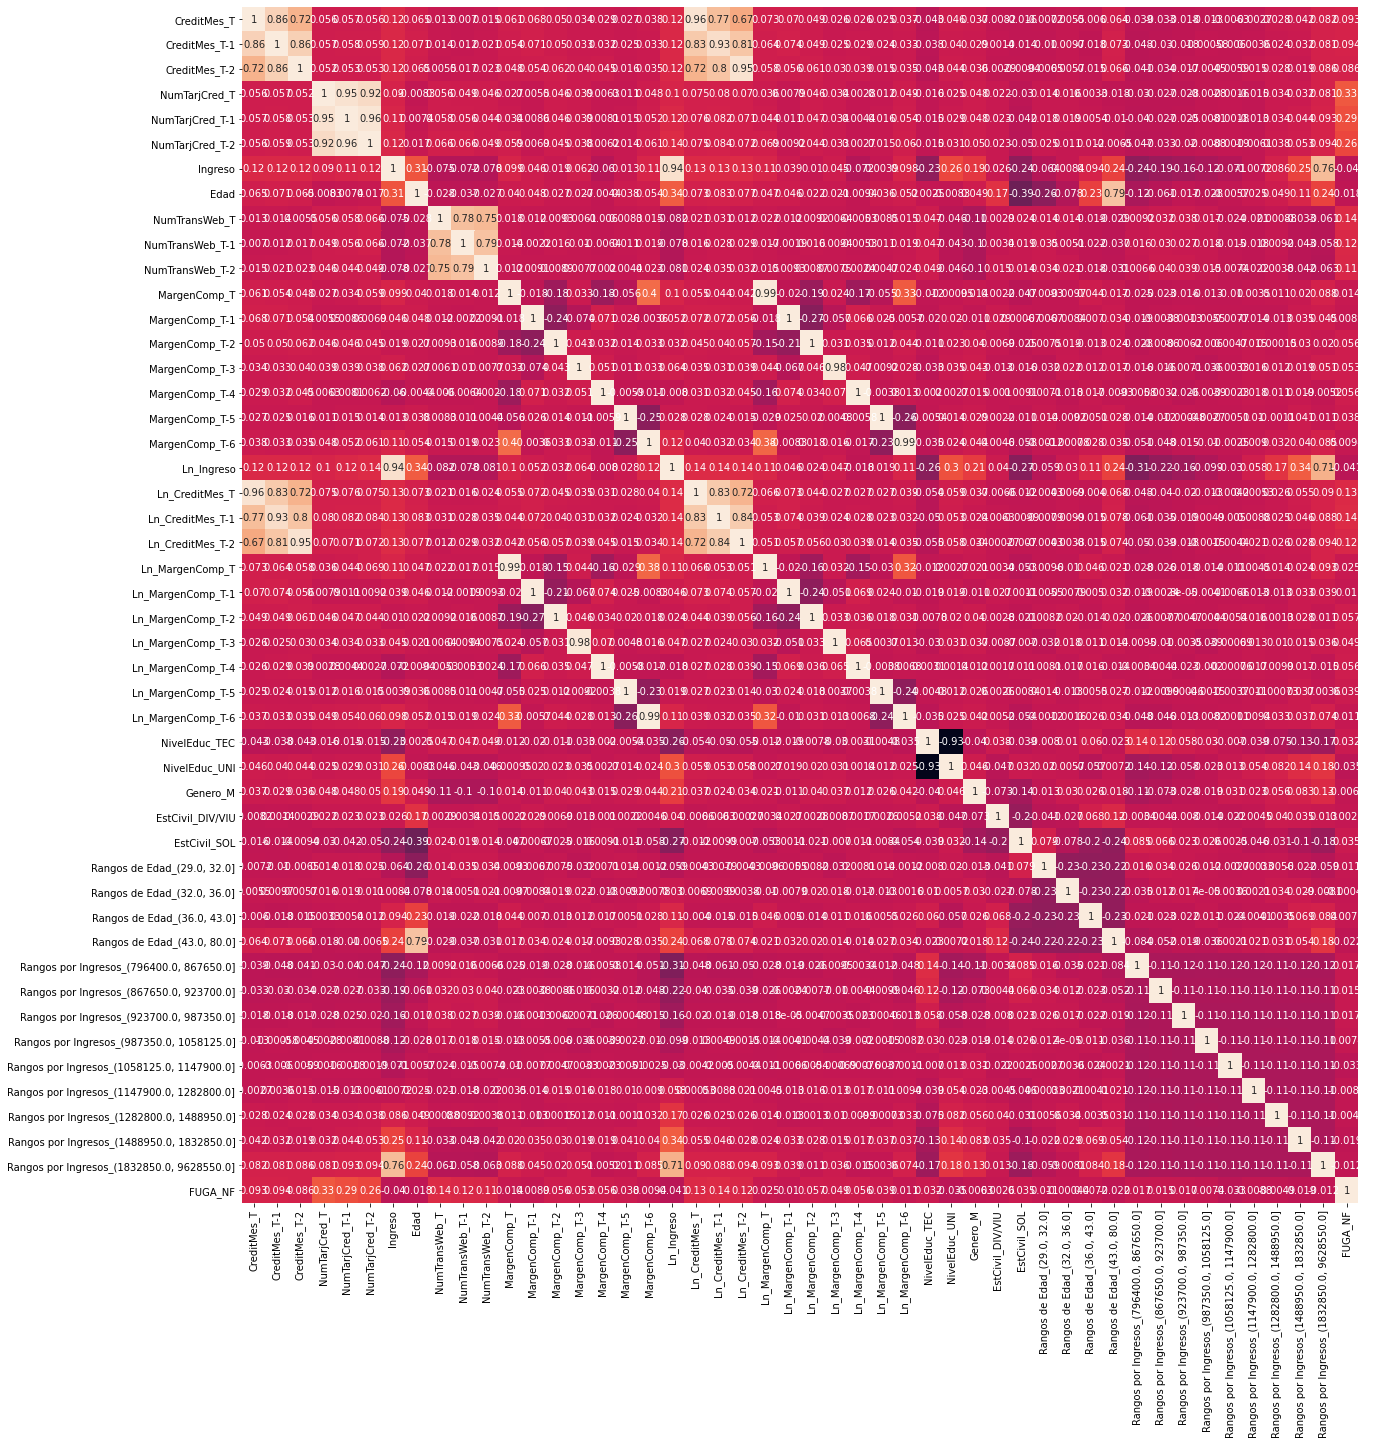

In [ ]:
plt.figure(figsize=(20, 22))
sn.heatmap(df2.corr(), annot=True, cbar=False)